<a href="https://colab.research.google.com/github/kokchun/Machine-learning-AI22/blob/main/Lecture_code/L4-Regularization.ipynb" target="_parent"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp; for interacting with the code


---
# Lecture notes - Regularized linear models
---
Read more:

- [Regularized linear models medium](https://medium.com/analytics-vidhya/regularized-linear-models-in-machine-learning-d2a01a26a46)
- [Ridge regression wikipedia](https://en.wikipedia.org/wiki/Ridge_regression)
- [Tikhonov regularization wikipedia](https://en.wikipedia.org/wiki/Tikhonov_regularization)
- [Lasso regression wikipedia](https://en.wikipedia.org/wiki/Lasso_(statistics))
- [Korsvalidering](https://sv.wikipedia.org/wiki/Korsvalidering)
- [Cross validation](https://machinelearningmastery.com/k-fold-cross-validation/)
- [Scoring parameter sklearn](https://scikit-learn.org/stable/modules/model_evaluation.html)

---


In [11]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

---
## Data preparation

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

df = pd.read_csv("../data/Advertising.csv", index_col=0)
X, y = df.drop("Sales", axis = 1), df["Sales"]
model_polynomial = PolynomialFeatures(3, include_bias=False)
poly_features = model_polynomial.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(poly_features, y, test_size=0.33, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((134, 19), (66, 19), (134,), (66,))

---
## Feature standardization
Remove sample mean and divide by sample standard deviation 

$X' = \frac{X-\mu}{\sigma}$

LASSO, Ridge and Elasticnet regression that we'll use later require that the data is scaled.


In [13]:
from sklearn.model_selection import  train_test_split
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

print(f"Scaled X_train mean {scaled_X_train.mean():.2f}, std {scaled_X_train.std():.2f}")
print(f"Scaled X_test mean {scaled_X_test.mean():.2f}, std {scaled_X_test.std():.2f}")


Scaled X_train mean -0.00, std 1.00
Scaled X_test mean -0.12, std 1.12


---
## Regularization techniques

Problem with overfitting was discussed in previous lecture. When model is too complex, data noisy and dataset is too small the model picks up patterns in the noise. The output of a linear regression is the weighted sum: 
$y = \theta_0 + \theta_1x_1 + \theta_2x_2 + \ldots + \theta_nx_n$ , where the weights $\theta_i$ represents the importance of the $ith$ feature. Want to constrain the weights associated with noise, through regularization. We do this by adding a regularization term to the cost function used in training the model. Note that the cost function for evaluation now will differ from the training.

<p class = "alert alert-info" role="alert"><b>Note</b> most regularization model requires scaling of data </p>

---
### Ridge regression 
Also called Tikhonov regularization or $\ell_2$ regularization.

$C(\vec{\theta}) = MSE(\vec{\theta}) + \lambda \frac{1}{2}\sum_{i=1}^n \theta_i^2$

where $\lambda \ge 0$ is the ridge parameter or the penalty term, which reduces variance by increasing bias. Observe that the sum starts from 1, so the bias term $\theta_0$ is not affected by $\lambda$. Therefore by the larger the $\lambda$ the more $\theta_i, i = {1,2,\ldots}$ causes higher error. As variance is decreasing and bias increasing, the model fits worse to the training datas noise and generalizes better.

From the closed form OLS solution to ridge regression, we see that $\lambda = 0$ gives us the normal equation for linear regression: 

$\hat{\vec{\theta}} = (X^TX + \lambda I)^{-1}X^T\vec{y}$



In [14]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error

def ridge_regression(X, penalty=0):
    # alpha = 0 should give linear regression
    # note that alhpa is same as lambda in theory, i.e. penalty term. sklearn has chosen alpha to generalize their API
    model_ridge = Ridge(alpha=penalty) 
    model_ridge.fit(scaled_X_train, y_train)
    y_pred = model_ridge.predict(X)
    return y_pred


y_pred = ridge_regression(scaled_X_test, 0.1)
MSE = mean_squared_error(y_test, y_pred)
RMSE = np.sqrt(MSE)

RMSE, mean_absolute_error(y_test, y_pred)


(np.float64(0.56358991694679), 0.4343075766387518)

In [15]:
# check with linear regression -> RMSE very similar!
from sklearn.linear_model import LinearRegression
model_linear = LinearRegression()
model_linear.fit(scaled_X_train, y_train)
y_pred = model_linear.predict(scaled_X_test)
np.sqrt(mean_squared_error(y_test, y_pred)), mean_absolute_error(y_test, y_pred)

(np.float64(0.514826762178659), 0.3748516441217817)

In [16]:
from sklearn.linear_model import Lasso
model_lasso = Lasso(alpha = .1)
model_lasso.fit(scaled_X_train, y_train)
y_pred = model_lasso.predict(scaled_X_test)
np.sqrt(mean_squared_error(y_test, y_pred)), mean_absolute_error(y_test, y_pred)
print(model_lasso.coef_)

[ 1.89480144  0.42062367  0.         -0.          3.55216501  0.
  0.          0.01110965  0.         -0.42677394 -0.         -0.
  0.          0.         -0.          0.          0.06706906  0.
  0.        ]


### k-fold cross-validation

One strategy to choose the best hyperparameter alpha is to take the training part of the data and 
1. shuffle dataset randomly
2. split into k groups
3. for each group -> take one test, the rest training -> fit the model -> predict on test -> get evaluation metric
4. take the mean of the evaluation metrics
5. choose the parameters and train on the entire training dataset

Repeat this process for each alpha, to see which yielded lowest RMSE. k-fold cross-validation: 
- good for smaller datasets
- fair evaluation, as a mean of the evaluation metric for all k groups is calculated
- expensive to compute as it requires k+1 times of training

---
### Ridge regression

In [ ]:
from sklearn.linear_model import RidgeCV # ridge regression with cross-validation

model_ridgeCV = RidgeCV(alphas = [.0001, .001, .01, .1, .5, 1, 5, 10], scoring = "neg_mean_squared_error")
model_ridgeCV.fit(scaled_X_train, y_train)
print(model_ridgeCV.alpha_)


0.1


In [18]:
# best alpha is 0.1
# it seems that linear regression outperformed ridge regression in this case
# however it could depend on the distribution of the train|test data, so using alpha = 0.1 is more robust here
y_pred = model_ridgeCV.predict(scaled_X_test)
RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
RMSE, mean_absolute_error(y_test, y_pred)

(np.float64(0.5635899169537046), 0.43430757664503)

In [19]:
model_ridgeCV.coef_

array([ 5.84681185,  0.52142086,  0.71689997, -6.17948738,  3.75034058,
       -1.36283352, -0.08571128,  0.08322815, -0.34893776,  2.16952446,
       -0.47840838,  0.68527348,  0.63080799, -0.5950065 ,  0.61661989,
       -0.31335495,  0.36499629,  0.03328145, -0.13652471])

### Lasso regression

In [20]:
from sklearn.linear_model import LassoCV

# it is trying 100 different alphas along regularization path epsilon
model_lassoCV = LassoCV(eps = 0.001, n_alphas = 100, max_iter=10000, cv=5)
model_lassoCV.fit(scaled_X_train, y_train)
print(f"alpha = {model_lassoCV.alpha_}")

y_pred = model_lassoCV.predict(scaled_X_test)

np.sqrt(mean_squared_error(y_test, y_pred)), mean_absolute_error(y_test, y_pred)


alpha = 0.004968802520343366


/home/raphael/code/.venv/lib/python3.14/site-packages/sklearn/linear_model/_coordinate_descent.py:1663: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(


(np.float64(0.5785146895302028), 0.4629188302693353)

In [21]:
# we notice that many coefficients have been set to 0 using Lasso
# it has selected some features for us 
model_lassoCV.coef_

array([ 5.19612354,  0.43037087,  0.29876351, -4.80417579,  3.46665205,
       -0.40507212,  0.        ,  0.        ,  0.        ,  1.35260206,
       -0.        ,  0.        ,  0.14879719, -0.        ,  0.        ,
        0.        ,  0.09649665,  0.        ,  0.04353956])

Another visualization, this one on the 'diabetes' dataset.

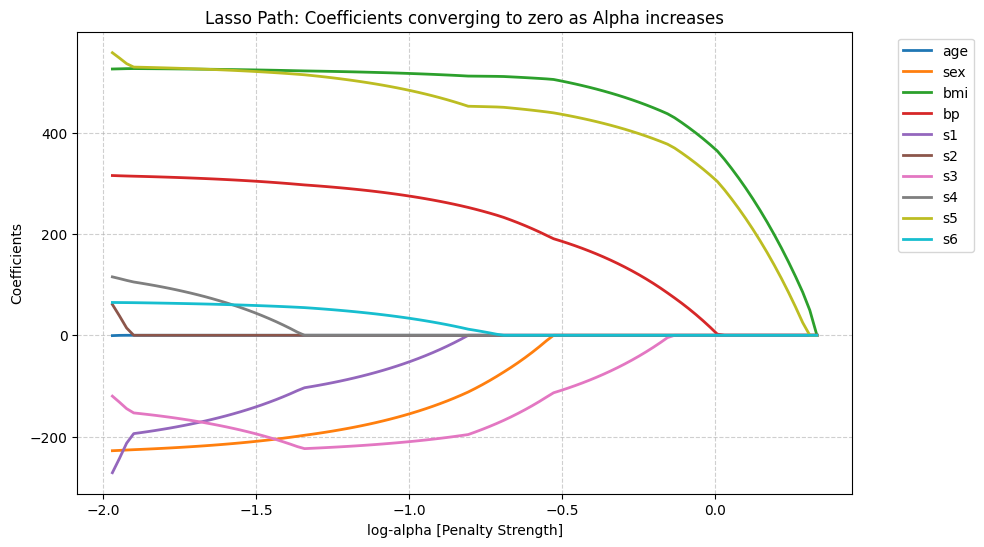

In [22]:
#Code produces lasso path on diabetes dataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.linear_model import lasso_path

diabetes = datasets.load_diabetes()
X, y = diabetes.data, diabetes.target
alphas_lasso, coefs_lasso, _ = lasso_path(X, y, eps=5e-3)
plt.figure(figsize=(10, 6))
log_alphas_lasso = np.log10(alphas_lasso)
for coef, name in zip(coefs_lasso, diabetes.feature_names):
    plt.plot(log_alphas_lasso, coef, label=name, linewidth=2)
plt.xlabel('log-alpha [Penalty Strength]')
plt.ylabel('Coefficients')
plt.title('Lasso Path: Coefficients converging to zero as Alpha increases')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### Elastic net

Elastic net is a combination of both Ridge l2-regularization and Lasso l1-regularization. The cost function to be minimized for elastic net is: 

$$C(\vec{\theta}) = MSE(\vec{\theta}) + \lambda\left(\alpha\sum_{i=1}^n |\theta_i| + \frac{1-\alpha}{2}\sum_{i=1}^n \theta_i^2\right)$$

, where $\alpha$ here determines the ratio for $\ell_1$ or $\ell_2$ regularization.

In [23]:
from sklearn.linear_model import ElasticNetCV

# note that alpha here is lambda in the theory
# l1_ratio is alpha in the theory
model_elastic = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], eps = 0.001, n_alphas = 100, max_iter=10000)
model_elastic.fit(scaled_X_train, y_train)
print(f"L1 ratio: {model_elastic.l1_ratio_}") # this would remove ridge and pick Lasso regression entirely
print(f"alpha {model_elastic.alpha_}")

/home/raphael/code/.venv/lib/python3.14/site-packages/sklearn/linear_model/_coordinate_descent.py:1663: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(


L1 ratio: 1.0
alpha 0.004968802520343366


In [24]:
y_pred = model_elastic.predict(scaled_X_test)
np.sqrt(mean_squared_error(y_test, y_pred)), mean_absolute_error(y_test, y_pred)
# note that the result is same for Lasso regression which is expected

(np.float64(0.5785146895302028), 0.4629188302693353)

---

Kokchun Giang, Raphael Korsoski

---
